Connect to [RACE](http://www.gitan.ulg.ac.be/cms/index.php?page=donnees-de-stareso#1.) database (*Rapid Assessment of the marine Coastal Environment*) and perform a simple data query.<br>
We will use the [psycopg2](https://wiki.postgresql.org/wiki/Psycopg2) package.

In [2]:
import psycopg2
import logging
import getpass
import sys
import matplotlib.pyplot as plt

# Prerequisites

1. You need to have a user name and password to access the database.
2. If you're not using the ULg network (wired or wireless), it is necessary to use the ULg Virtual Private Network (VPN), otherwise the connection won't be authorised.

# Configuration

## Logging

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Define the query

If you're not familiar with the querly language, use [`pgadmin`](https://www.pgadmin.org/) (graphical administration tool for [PostgreSQL](https://www.postgresql.org/)) to prepare the request using the graphical interface.<br>
Most of the interesting data are stored in one of these tables:
* data,
* timeseries,
* profiledata.

In the following query, we want to obtain the *wind speed* variable acquired from April 1st 2017 on.

`data.dasa_codeds` and<br> 
`timeseries.codeds`<br>
are the *Primary Keys* (PK) that allow us to join the 2 tables `data` and `timeseries`. 

In [6]:
windquery = """SELECT
  data.datavalue,
  data.daytime,
  data.dataparam_codeparam
FROM
  public.data,
  public.timeseries
WHERE
  data.dasa_codeds = timeseries.codeds AND
  timeseries.tssta_codesta = 'INSJD' AND
  data.daytime > '2017-04-01 00:00:00' AND
  data.dataparam_codeparam = 'windspeed'
GROUP BY
  data.dataparam_codeparam,
  data.datavalue,
  data.daytime
ORDER BY
  data.daytime;
  """

We just need to make sure no *new lines* are present in the string:

In [7]:
windquery = windquery.replace('\n', ' ')

## Connection setup

You need to have an access to the database.

In [8]:
dbuser = getpass.getpass(prompt="Enter user name:")

Enter user name:········


In [13]:
dbpa = getpass.getpass(prompt="Enter word:")

Enter word:········


In [14]:
conn = psycopg2.connect(host='10.16.8.17', user=dbuser, password=dbpa, dbname="race_db_v2")

If you get an `OperationalError`, check if your VPN connection was properly set up.

### Connection status

In [15]:
if conn.status == psycopg2.extensions.STATUS_READY:
    logging.info("Status: ready")
elif conn.status == psycopg2.extensions.STATUS_BEGIN:
    logging.info("Status: begin")
elif conn.status == psycopg2.extensions.STATUS_IN_TRANSACTION:
    logging.info("Status: in transaction")
elif conn.status == psycopg2.extensions.STATUS_PREPARED:
    logging.info("Status: prepared")
else:
    logging.error("Uncorrect status")

INFO:root:Status: ready


# Execute request

Open a [cursor](https://en.wikipedia.org/wiki/Cursor_(databases)) to perform database operations:

In [16]:
cur = conn.cursor()

Execute a command: this creates a new table

In [19]:
cur.execute(windquery)

## Read the data into a variable

In [20]:
data = cur.fetchall()

Close the cursor and the connection:

In [21]:
cur.close()
conn.close()

## Parse the data

The data obtained are in the form of a list of tuples:

In [23]:
logging.debug(type(data))
logging.debug(data[0])

DEBUG:root:<class 'list'>
DEBUG:root:(0.1554, datetime.datetime(2017, 4, 1, 0, 4), 'windspeed')


We convert the list of tuples to two separate lists:
* one for the wind speed mesurements,
* the other for the datatime objects.

In [24]:
windspeed, datetimelist = [], []
for dd in data:
    windspeed.append(dd[0])
    datetimelist.append(dd[1])

# Make a plot

In [ ]:
The `plot` function accepts the datetime as an argument.

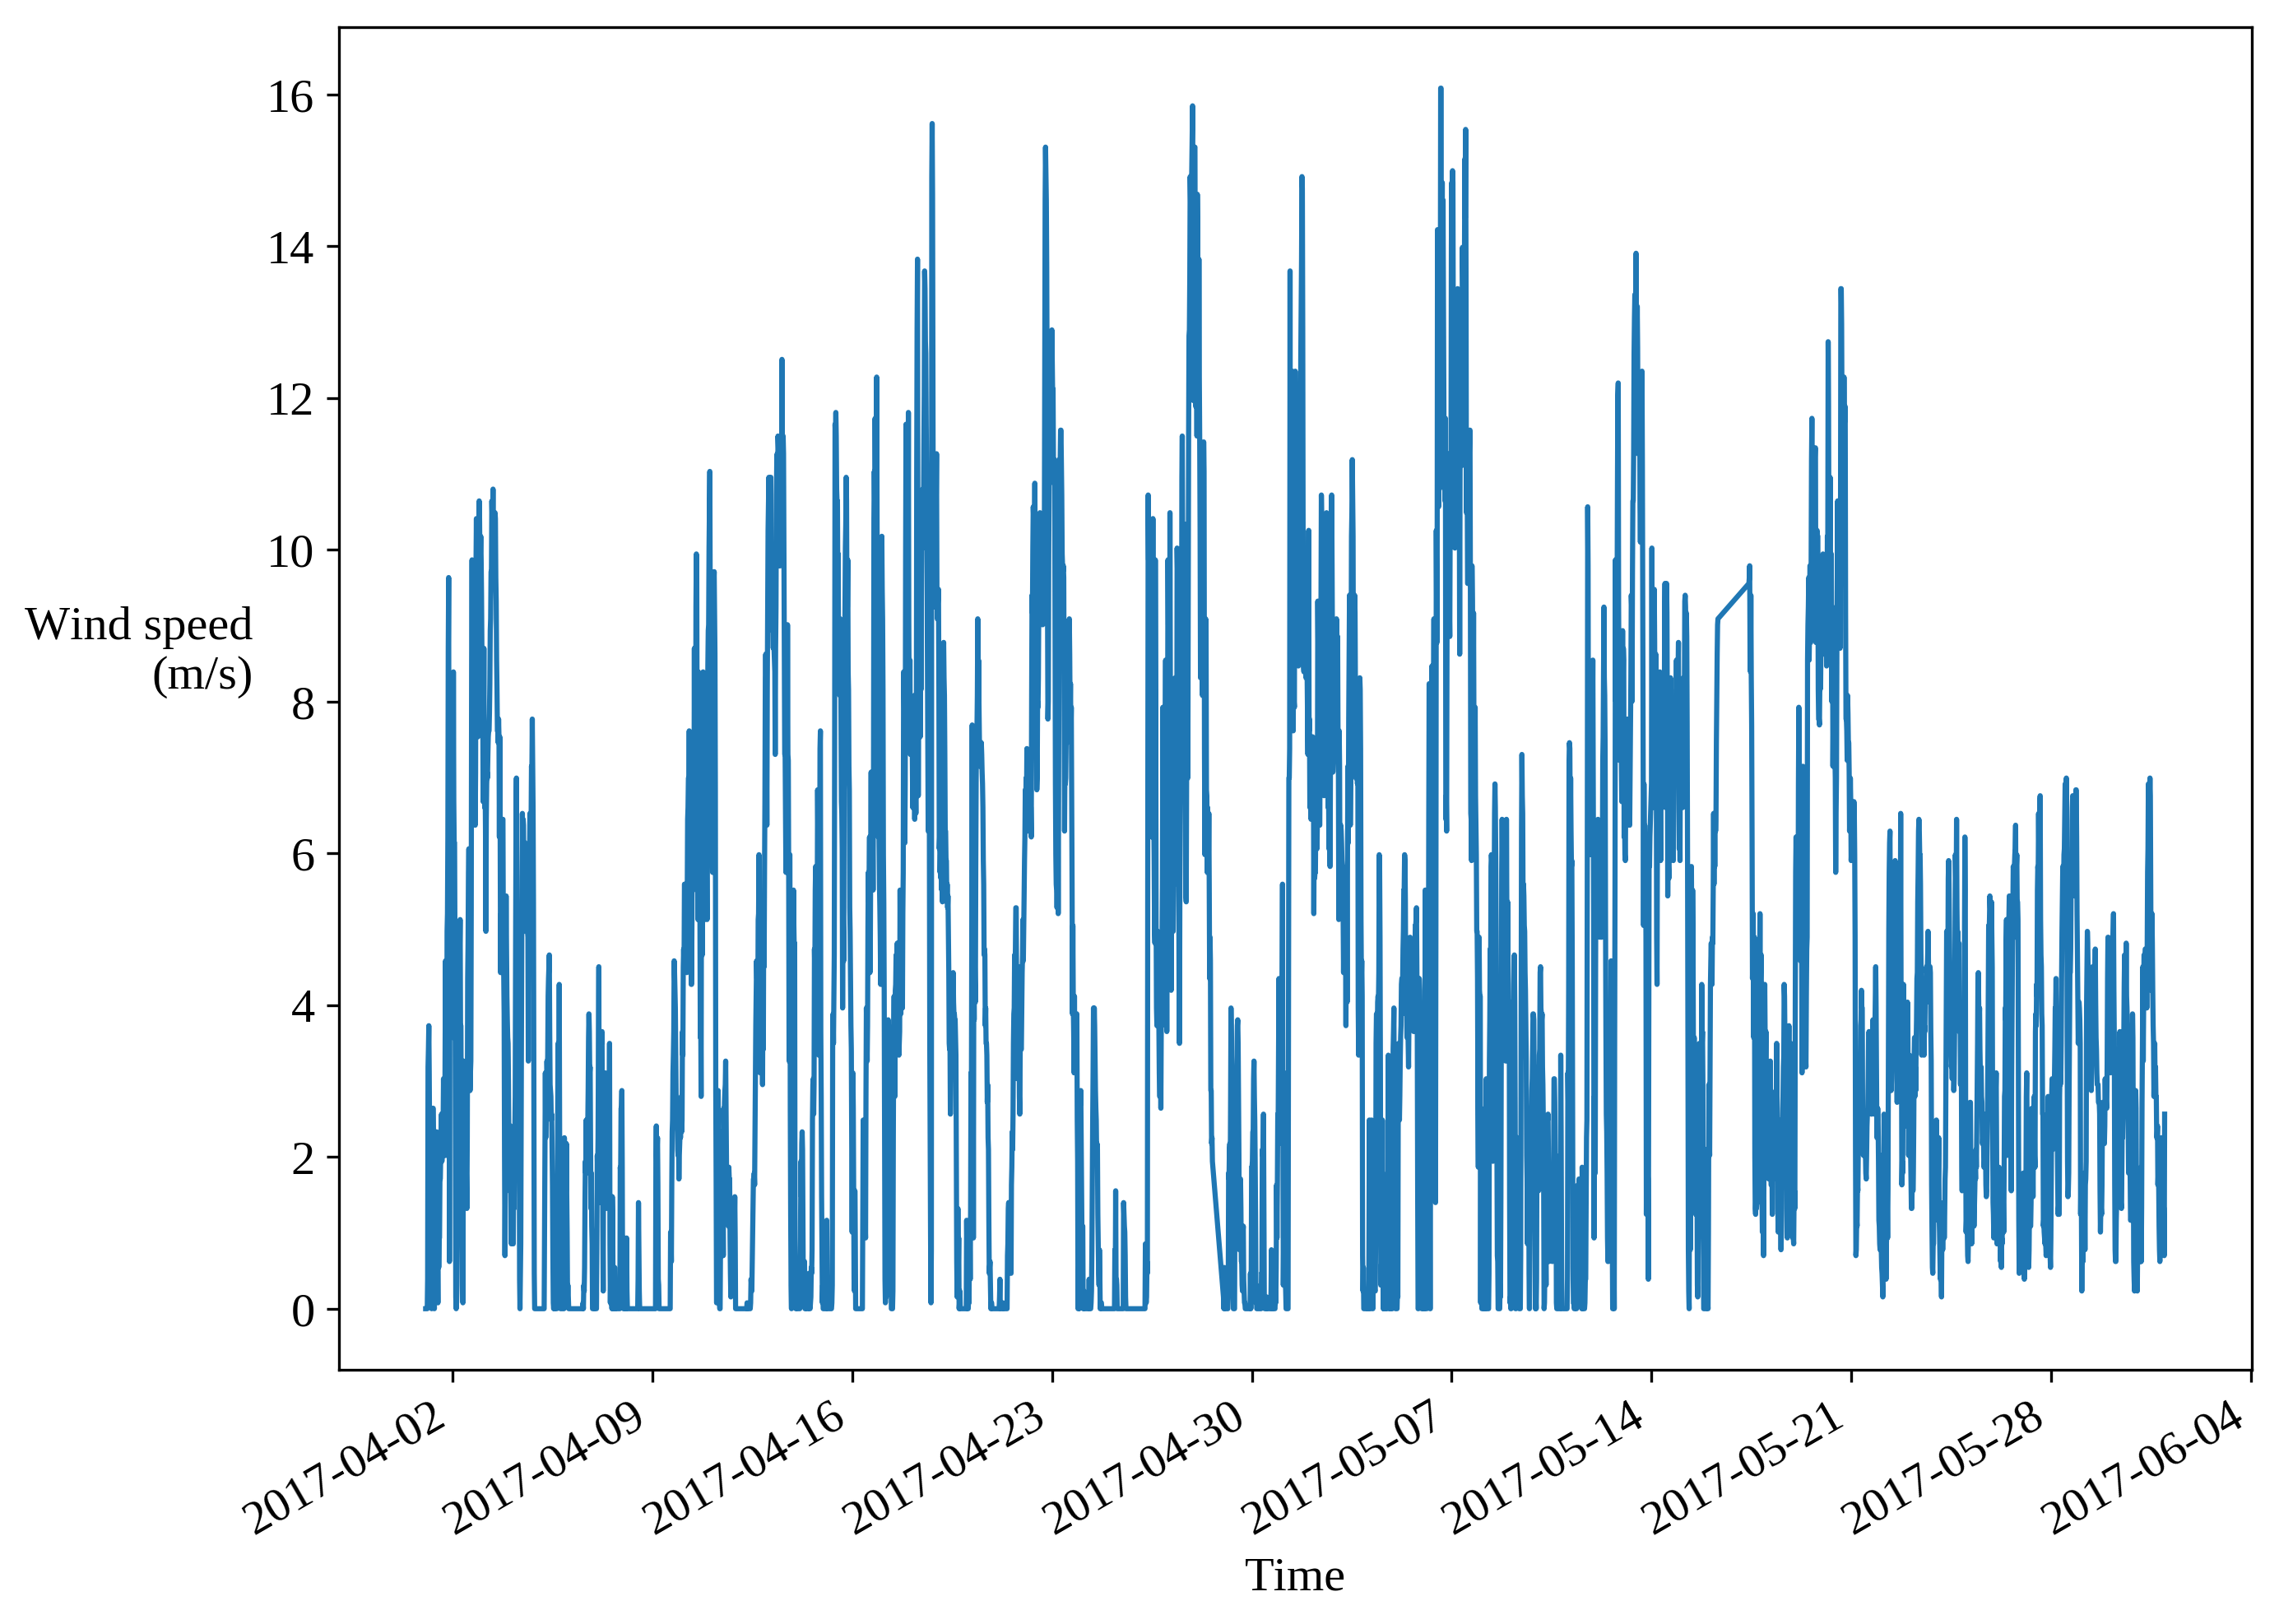

In [153]:
fig = plt.figure()
plt.plot(datetimelist, windspeed)
plt.xlabel("Time")
plt.ylabel("Wind speed\n(m/s)", rotation=0, ha='right')
fig.autofmt_xdate()
plt.show()
plt.close()